# Analisi ATP

## Importazione dati e librerie

### Librerie

In [25]:
# Per importazione del dataset da Kaggle
import kagglehub

# Per la manipolazione dei dati
import pandas as pd
import numpy as np

# Per la visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns

# Per la gestione delle date
from datetime import datetime

# Per il preprocessing e il machine learning 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Impostazioni grafiche per Seaborn
sns.set_theme(style="whitegrid")


### Import dati

In [26]:
# importazione del dataset direttamente da Kaggle
path = kagglehub.dataset_download("dissfya/atp-tennis-2000-2023daily-pull")

In [27]:
# lettura del csv importato, concatenado la stringa del percorso che abbiamo nella variabile path con il nome del dataset
df = pd.read_csv(path + "/atp_tennis.csv")

### Prima visualizzazione

In [28]:
# visualizzazione
df.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score
0,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,Dosedel S.,63,77,-1,-1,-1.0,-1.0,6-4 6-2
1,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Clement A.,Enqvist T.,Enqvist T.,56,5,-1,-1,-1.0,-1.0,3-6 3-6
2,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,Escude N.,40,655,-1,-1,-1.0,-1.0,6-7 7-5 6-3
3,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Knippschild J.,Federer R.,Federer R.,87,65,-1,-1,-1.0,-1.0,1-6 4-6
4,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,Woodbridge T.,Fromberg R.,81,198,-1,-1,-1.0,-1.0,7-6 5-7 6-4


In [29]:
# controllo della tipologia dei dati contenuti nelle colonne
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65297 entries, 0 to 65296
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tournament  65297 non-null  object 
 1   Date        65297 non-null  object 
 2   Series      65297 non-null  object 
 3   Court       65297 non-null  object 
 4   Surface     65297 non-null  object 
 5   Round       65297 non-null  object 
 6   Best of     65297 non-null  int64  
 7   Player_1    65297 non-null  object 
 8   Player_2    65297 non-null  object 
 9   Winner      65297 non-null  object 
 10  Rank_1      65297 non-null  int64  
 11  Rank_2      65297 non-null  int64  
 12  Pts_1       65297 non-null  int64  
 13  Pts_2       65297 non-null  int64  
 14  Odd_1       65297 non-null  float64
 15  Odd_2       65297 non-null  float64
 16  Score       65297 non-null  object 
dtypes: float64(2), int64(5), object(10)
memory usage: 8.5+ MB
None


### Pulizia Dati

In [30]:
# Rimuoviamo tutte le righe che contengono valori mancanti (NaN) nelle colonne fondamentali per il nostro modello.
# In questo caso consideriamo fondamentali: ranking, punti, superficie e numero di set.
df = df.dropna(subset=[
    'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2',
    'Surface', 'Best of'
])

# pulizia dal dataframe da valori non validi per i punti e per il ranking
df = df[(df['Pts_1'] > 0) & (df['Pts_2'] > 0)]
df = df[(df['Rank_1'] > 0) & (df['Rank_2'] > 0)]

# Filtriamo le partite con quote valide (diverse da -1 o -1.00)
# Alcune righe hanno valori negativi che indicano quote mancanti → le togliamo
df = df[(df['Odd_1'] > 1) & (df['Odd_2'] > 1)]

### Aggiunta Variabili

In [31]:
# Aggiunta di nuove variabili

# differenza di ranking tra Player_2 e Player_1
# Un valore positivo indica che Player_1 è più in alto nel ranking rispetto a Player_2
df['Rank_Gap'] = df['Rank_2'] - df['Rank_1']

# Winner_Player1
# Creiamo una nuova colonna chiamata "Winner_Player1" che vale 1 se il vincitore è Player_1, altrimenti 0.
df['Winner_Player1'] = (df['Winner'] == df['Player_1']).astype(int)

In [32]:
df.head()

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score,Rank_Gap,Winner_Player1
15652,Swedish Open,2005-07-04,International,Outdoor,Clay,1st Round,3,Robredo T.,Tabara M.,Robredo T.,20,112,1425,381,1.10,6.00,7-5 6-0,92,1
15653,Swedish Open,2005-07-04,International,Outdoor,Clay,1st Round,3,Ryderstedt M.,Vinciguerra A.,Vinciguerra A.,132,917,326,9,1.66,2.10,3-6 1-6,785,0
15654,Swedish Open,2005-07-05,International,Outdoor,Clay,1st Round,3,Youzhny M.,Haehnel J.,Youzhny M.,27,109,1200,391,1.19,4.00,6-1 6-1,82,1
15655,Swedish Open,2005-07-05,International,Outdoor,Clay,1st Round,3,Dlouhy L.,Ferrero J.C.,Ferrero J.C.,136,31,315,1150,7.00,1.07,4-6 1-6,-105,0
15656,Swedish Open,2005-07-05,International,Outdoor,Clay,1st Round,3,Berdych T.,Kim K.,Berdych T.,42,71,811,541,1.19,4.00,6-2 6-3,29,1


## Analisi preliminari


#### Atleti più vincenti

In [33]:
# elenco degli atleti che hanno vinto più partite 
vittorie = df['Winner'].value_counts()
print(vittorie.head(10))

Djokovic N.    1014
Nadal R.        901
Federer R.      801
Murray A.       661
Ferrer D.       594
Berdych T.      551
Monfils G.      539
Gasquet R.      535
Cilic M.        529
Wawrinka S.     523
Name: Winner, dtype: int64


#### Vittorie per slam

In [34]:
# filtro del dataset con i tornei Slam e le finali
slams = ['Australian Open', 'French Open', 'Wimbledon', 'US Open']
df_slams = df[(df['Tournament'].isin(slams)) & (df['Round'] == 'The Final')]

# raggruppamento per vincitori e per tornei
slam_titles = df_slams.groupby(['Winner', 'Tournament']).size().reset_index(name='Titles')

# creazione della pivot ed ordinamento per quantità di Slam vinti
pivot_df = slam_titles.pivot(index='Winner', columns='Tournament', values='Titles').fillna(0).astype(int)
pivot_df['Total Slam Titles'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='Total Slam Titles', ascending=False).reset_index()

pivot_df

Tournament,Winner,Australian Open,French Open,US Open,Wimbledon,Total Slam Titles
0,Djokovic N.,10,3,4,7,24
1,Nadal R.,2,13,3,2,20
2,Federer R.,5,1,4,5,15
3,Alcaraz C.,0,1,1,2,4
4,Murray A.,0,0,1,2,3
5,Sinner J.,2,0,1,0,3
6,Wawrinka S.,1,1,1,0,3
7,Cilic M.,0,0,1,0,1
8,Del Potro J.M.,0,0,1,0,1
9,Medvedev D.,0,0,1,0,1


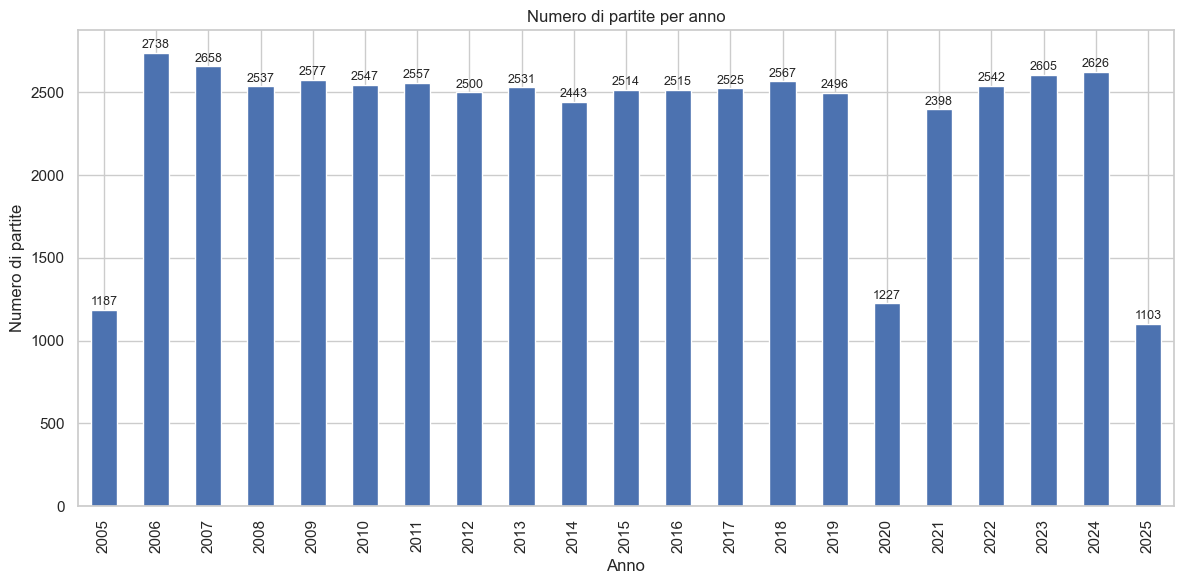

In [35]:
# trasformazione date in datetime
df['year'] = pd.to_datetime(df['Date']).dt.year

# conteggio dei match per ogni anno
matches_per_year = df['year'].value_counts().sort_index()

# composizione del grafico
ax = matches_per_year.plot(kind='bar', figsize=(12,6))
plt.title('Numero di partite per anno')
plt.xlabel('Anno')
plt.ylabel('Numero di partite')

# aggiunta delle etichette del numero di partite per anno
for i, value in enumerate(matches_per_year):
    ax.text(i, value + 10, str(value), ha='center', va='bottom', fontsize=9)

# visualizzazione del grafico
plt.tight_layout()
plt.show()


#### Analisi di correlazione

In [36]:
# Analisi di correlazione tra Winner_Player1 e tutte le altre variabili numeriche

# Selezioniamo solo le colonne numeriche
numeric_cols = df.select_dtypes(include=['number']).columns

# Calcoliamo la correlazione di Winner_Player1 con tutte le altre variabili numeriche
correlations = df[numeric_cols].corr()['Winner_Player1'].sort_values(ascending=False)

# Visualizziamo la correlazione
print("Correlazione di Winner_Player1 con le altre variabili numeriche:")
print(correlations)


Correlazione di Winner_Player1 con le altre variabili numeriche:
Winner_Player1    1.000000
Odd_2             0.320334
Rank_Gap          0.236666
Pts_1             0.205354
Rank_2            0.158681
year              0.000344
Best of           0.000036
Rank_1           -0.165440
Pts_2            -0.209351
Odd_1            -0.323397
Name: Winner_Player1, dtype: float64


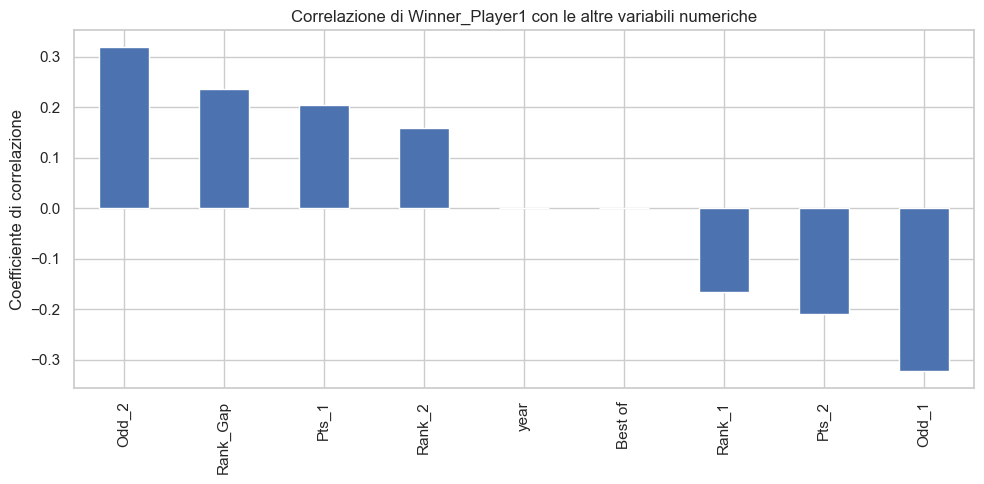

In [37]:
# Visualizzazione grafica delle correlazioni (escludendo Winner_Player1 stesso)
correlations.drop('Winner_Player1').plot(kind='bar', figsize=(10,5))
plt.title('Correlazione di Winner_Player1 con le altre variabili numeriche')
plt.ylabel('Coefficiente di correlazione')
plt.tight_layout()
plt.show()

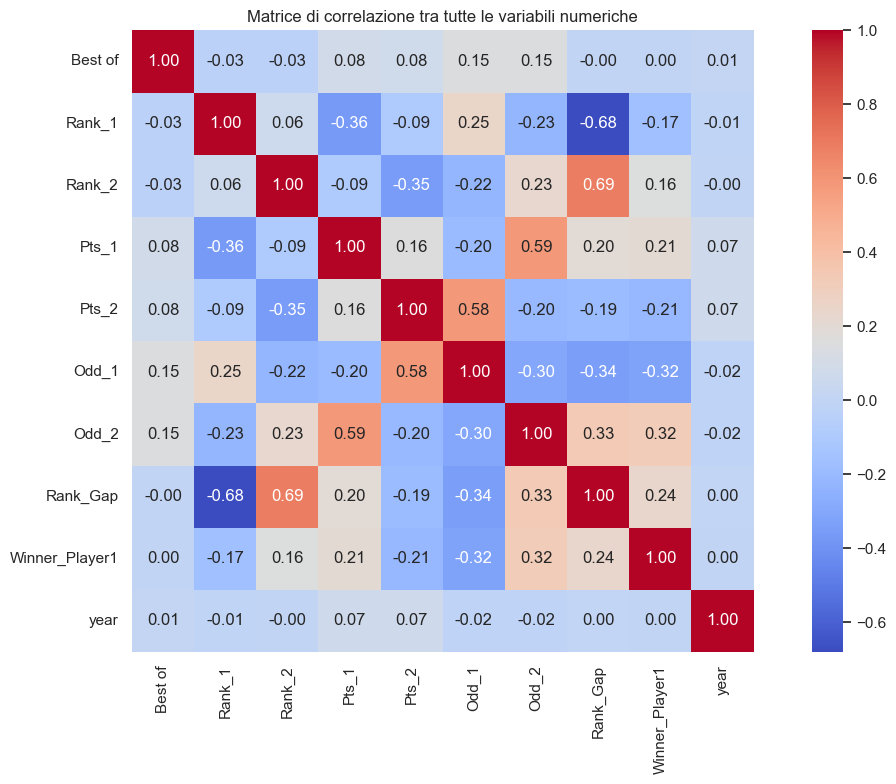

In [38]:
# Genera e visualizza una matrice di correlazione tra tutte le variabili numeriche
# Seleziona solo le colonne numeriche per evitare errori con colonne stringa
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matrice di correlazione tra tutte le variabili numeriche')
plt.tight_layout()
plt.show()

##### Le variabili che più influenzano la vittoria del Player1 sono le quote dei bookmaker (Odd_1 e Odd_2), il gap di ranking e i punti dei giocatori. Le altre variabili hanno un impatto molto basso o trascurabile sulla probabilità di vittoria del Player1.

## Analisi Predittiva

#### **La Random Forest** 
è un algoritmo di machine learning supervisionato che **serve a prevedere una variabile target** (Nel nostro caso la vittoria o sconfitta di un giocatore) a partire da altre variabili dette  **feature**.

##### **Come funziona**
- **Costruzione di alberi decisionali**:
La Random Forest genera tanti alberi decisionali, ognuno addestrato su un sottoinsieme casuale dei dati e delle feature.
Ogni albero cerca di prevedere la variabile target in modo indipendente.
- **Predizione combinata**:
Se la variabile target è categorica (classificazione), ogni albero “vota” per una classe e la classe più votata è la predizione finale.
Se la variabile target è numerica (regressione), la previsione finale è la media delle previsioni di tutti gli alberi.

### Preparazione dati

In [39]:
# STEP 1 – Encoding delle variabili categoriche
# Alcune colonne contengono valori testuali (come "Clay", "Grass", "Hard" per la superficie).
# Per poterle usare nel modello, le trasformiamo in numeri interi tramite la codifica delle categorie.
# Ogni valore unico viene trasformato in un numero (ad esempio: Clay=0, Grass=1, Hard=2...).
df['Surface'] = df['Surface'].astype('category').cat.codes
df['Series'] = df['Series'].astype('category').cat.codes
df['Court'] = df['Court'].astype('category').cat.codes
df['Round'] = df['Round'].astype('category').cat.codes

# STEP 2 – Scelta delle variabili di input (feature)
# Selezioniamo le colonne che vogliamo usare per fare le previsioni.
# Sono tutte colonne numeriche che contengono informazioni utili per predire l'esito della partita.
features = [
   
    'Pts_1', 'Pts_2',
    'Surface', 'Series', 'Court', 'Round',
    'Best of', 'Rank_Gap'
]
# STEP 3 – Costruzione della matrice X e del target y
# X contiene tutte le righe complete delle feature selezionate.
# y è la nostra variabile da predire, ovvero Winner_Player1.
X = df[features].dropna()
y = df.loc[X.index, 'Winner_Player1']

# STEP 4 – Divisione in dati di addestramento e di test
# Suddividiamo i dati in due insiemi: uno per allenare il modello (80%) e uno per testarlo (20%).
# Usiamo un random_state per rendere i risultati ripetibili.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Creazione e addestramento del modello

In [40]:
# Creiamo un modello di classificazione Random Forest con 200 alberi decisionali.
# L’algoritmo impara dagli esempi nel training set come distinguere tra vittoria e sconfitta di Player_1.
model = RandomForestClassifier(n_estimators=200, max_depth = 2, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_estimators=200, random_state=42)

### Valuztazione del modello

In [41]:

# STEP 1 – Valutazione del modello
# Usiamo il modello per fare previsioni sulle partite del test set.
# Poi calcoliamo l’accuratezza e stampiamo un report dettagliato con le metriche di classificazione.
y_pred = model.predict(X_test)

print(f"Accuratezza del modello: {accuracy_score(y_test, y_pred):.2%}")
print("\nReport di classificazione:")
print(classification_report(y_test, y_pred))
print("\nMatrice di confusione:")
print(confusion_matrix(y_test, y_pred))

# STEP 2 – Analisi dell’importanza delle feature
# Dopo l’addestramento, possiamo analizzare quanto ciascuna variabile ha contribuito alle decisioni del modello.
# Usiamo un grafico a barre orizzontali per visualizzare l’importanza relativa di ciascuna feature.
importanze = model.feature_importances_
importanza_serie = pd.Series(importanze, index=features).sort_values(ascending=True)

Accuratezza del modello: 65.53%

Report di classificazione:
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      4919
           1       0.66      0.65      0.65      4960

    accuracy                           0.66      9879
   macro avg       0.66      0.66      0.66      9879
weighted avg       0.66      0.66      0.66      9879


Matrice di confusione:
[[3268 1651]
 [1754 3206]]


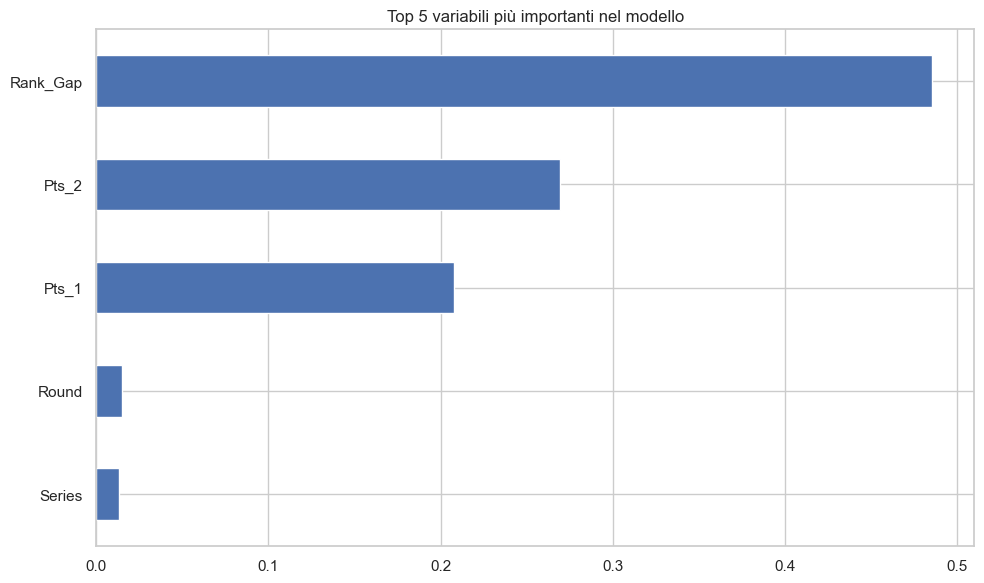

In [42]:
# STEP 3 – Visualizzazione
plt.figure(figsize=(10, 6))
importanza_serie.tail(5).plot(kind='barh')
plt.title("Top 5 variabili più importanti nel modello")
plt.tight_layout()


#### Commento

Abbiamo ottenuto un’accuratezza del 65.53%, con valori di precision, recall e f1-score bilanciati tra le due classi (vittoria di Player_1 o Player_2). Questo suggerisce una buona stabilità del modello, anche se con possibili margini di miglioramento.

La matrice di confusione mostra un numero simile di errori per entrambe le classi, a conferma di un comportamento non sbilanciato.

Analisi dell’importanza delle variabili:
Le variabili con maggiore impatto sono:

Rank_Gap (differenza tra i ranking dei due giocatori)

I punti ATP dei giocatori (Pts_1 e Pts_2)

Seguono, con un’influenza decisamente minore:

Round, Series e Surface

Mentre Court e Best of sembrano avere un impatto trascurabile sulle previsioni del modello.

## Analisi accuratezza Quote Bookmaker → quante volte ci hanno preso?

#### Preparazione dati

In [43]:
# Resettiamo l’indice per far funzionare correttamente il ciclo for
df = df.reset_index(drop=True)

# Creiamo una nuova colonna chiamata 'Bookmaker_Favorite'
# In questa colonna metteremo chi è il favorito secondo le quote
df['Bookmaker_Favorite'] = ''  # inizializziamo la colonna vuota

# Usiamo un ciclo for per assegnare riga per riga il favorito
for i in range(len(df)):
    if df.loc[i, 'Odd_1'] < df.loc[i, 'Odd_2']:
        df.loc[i, 'Bookmaker_Favorite'] = 'Player_1'
    else:
        df.loc[i, 'Bookmaker_Favorite'] = 'Player_2'

# Creiamo una colonna chiamata 'Bookmaker_Correct'
# Serve per capire se il favorito ha effettivamente vinto
df['Bookmaker_Correct'] = 0  # inizializziamo con 0

# Verifichiamo, sempre riga per riga, se il favorito ha vinto davvero
for i in range(len(df)):
    if df.loc[i, 'Bookmaker_Favorite'] == 'Player_1' and df.loc[i, 'Winner_Player1'] == 1:
        df.loc[i, 'Bookmaker_Correct'] = 1
    elif df.loc[i, 'Bookmaker_Favorite'] == 'Player_2' and df.loc[i, 'Winner_Player1'] == 0:
        df.loc[i, 'Bookmaker_Correct'] = 1
    # Altrimenti lasciamo 0 (cioè previsione sbagliata)

#### Calcolo accuratezza

In [44]:
# Facciamo la media dei valori della colonna 'Bookmaker_Correct'
accuracy = df['Bookmaker_Correct'].mean()

# Stampiamo il risultato in percentuale con due decimali
print(f"I bookmaker hanno previsto correttamente il vincitore nel {accuracy:.2%} dei casi.")

I bookmaker hanno previsto correttamente il vincitore nel 69.92% dei casi.


In [45]:
# mostriamo le prime 10 righe per vedere se tutto funziona bene
df[['Player_1', 'Player_2', 'Odd_1', 'Odd_2', 'Winner', 'Bookmaker_Favorite', 'Winner_Player1', 'Bookmaker_Correct']].head
df

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,...,Pts_1,Pts_2,Odd_1,Odd_2,Score,Rank_Gap,Winner_Player1,year,Bookmaker_Favorite,Bookmaker_Correct
0,Swedish Open,2005-07-04,3,1,1,0,3,Robredo T.,Tabara M.,Robredo T.,...,1425,381,1.10,6.00,7-5 6-0,92,1,2005,Player_1,1
1,Swedish Open,2005-07-04,3,1,1,0,3,Ryderstedt M.,Vinciguerra A.,Vinciguerra A.,...,326,9,1.66,2.10,3-6 1-6,785,0,2005,Player_1,0
2,Swedish Open,2005-07-05,3,1,1,0,3,Youzhny M.,Haehnel J.,Youzhny M.,...,1200,391,1.19,4.00,6-1 6-1,82,1,2005,Player_1,1
3,Swedish Open,2005-07-05,3,1,1,0,3,Dlouhy L.,Ferrero J.C.,Ferrero J.C.,...,315,1150,7.00,1.07,4-6 1-6,-105,0,2005,Player_2,1
4,Swedish Open,2005-07-05,3,1,1,0,3,Berdych T.,Kim K.,Berdych T.,...,811,541,1.19,4.00,6-2 6-3,29,1,2005,Player_1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49388,Hamburg Open,2025-05-22,1,1,1,4,3,Rublev A.,Darderi L.,Rublev A.,...,2540,1159,1.44,2.75,6-1 3-6 6-3,28,1,2025,Player_1,1
49389,Hamburg Open,2025-05-22,1,1,1,4,3,Muller A.,Auger-Aliassime F.,Auger-Aliassime F.,...,1313,1685,2.75,1.44,6-7 7-6 3-6,-10,0,2025,Player_2,1
49390,Hamburg Open,2025-05-23,1,1,1,6,3,Cobolli F.,Etcheverry T.,Cobolli F.,...,1480,975,2.10,1.73,2-6 7-5 6-4,20,1,2025,Player_2,0
49391,Hamburg Open,2025-05-23,1,1,1,6,3,Auger-Aliassime F.,Rublev A.,Rublev A.,...,1685,2540,2.10,1.73,1-6 4-6,-13,0,2025,Player_2,1


## Analisi Scontri diretti ATP Top 10

### Preparazione dati

In [46]:
# URL della pagina Wikipedia con la tabella deil Rank ATP
url = "https://it.wikipedia.org/wiki/Classifica_ATP"

# Legge tutte le tabelle della pagina
tables = pd.read_html(url)

# Seleziona la tabella giusta (la seconda nel nostro caso, indice 1)
df_rank = tables[1]

# Rinomina colonne per uniformità, la colonna rinominata Temp è una colonna non visibile nella pagina web 
df_rank.columns = ['Rank', 'Giocatore', 'Punti', 'Variazione', 'Temp']

# Pulisce i nomi
df_rank['Giocatore'] = df_rank['Giocatore'].str.replace(r"\s*\(.*?\)", "", regex=True) # Rimuove la parte del testo tra parentesi, che contiene la nazionalità, ad esempio: "Jannik Sinner (ITA)" diventa "Jannik Sinner".
df_rank['Giocatore'] = df_rank['Giocatore'].str.replace(r".*? ", "", regex=True) #Rimuove qualsiasi parte del nome che viene prima dello spazio (come la bandiera o il paese). Ad esempio, "Italia (bandiera) Jannik Sinner" 
                                                                                 #diventa solo "Jannik Sinner".

# Rimuove spazi non visibili (come &nbsp;) e altri caratteri non numerici
df_rank['Punti'] = df_rank['Punti'].astype(str).str.replace(r'\xa0', '', regex=True).str.replace(' ', '').str.replace('.', '', regex=False).astype(int)

# Seleziona la Top 10
top10 = df_rank[['Rank', 'Giocatore', 'Punti']].head(10)
top10.columns = ['Rank', 'Name', 'Pts']

top10

,Rank,Name,Pts
0,1,Sinner,10380
1,2,Alcaraz,8850
2,3,Zverev,7285
3,4,Fritz,4625
4,5,Draper,4610
5,6,Đoković,3980
6,7,Musetti,3860
7,8,Ruud,3655
8,9,Minaur,3635
9,10,Rune,3440


### Creazione combinazioni e stima quote

In [47]:
# creazione di tutte le combinazioni tra i primi 10 giocatori
combinations = []

# doppio ciclo annidato per generare le combinazioni
for i in range(len(top10)):
    for j in range(i+1, len(top10)):
        player_1 = top10.iloc[i]
        player_2 = top10.iloc[j]
        
        # composizione delle caratteristiche da passare al modello
        X_new = pd.DataFrame([{
            'Pts_1': player_1['Pts'],
            'Pts_2': player_2['Pts'],
            'Surface': 1,  # Aggiungi la tipologia del campo una nel nostro caso 1 = Clay
            'Series': 6,   # Aggiungi la tipologia sel torneo nel nostro caso 6 = Atp500
            'Court': 0,    # Aggiungi 1 se indoor 0 se outdoor
            'Round': 4,    # Aggiungi round, nel nostro caso 4 = The Final
            'Best of': 5,  # Aggiungi un "best of" nel nostro caso 5
            'Rank_Gap': player_2['Rank'] - player_1['Rank']
        }])

        # Probabilità di vittoria per Player_1
        prob_p1 = model.predict_proba(X_new)[0][1]
        prob_p2 = 1 - prob_p1

        # Quote attese
        odd_1_estimated = 1 / prob_p1
        odd_2_estimated = 1 / prob_p2
        
        combinations.append({
            'Player_1': player_1['Name'],
            'Player_2': player_2['Name'],
            'Prob_P1': prob_p1,
            'Prob_P2': prob_p2,
            'Odd_1_Estimated': odd_1_estimated,
            'Odd_2_Estimated': odd_2_estimated
        })

# Creazione di un DataFrame con le combinazioni
combinations_df = pd.DataFrame(combinations)
combinations_df

,Player_1,Player_2,Prob_P1,Prob_P2,Odd_1_Estimated,Odd_2_Estimated
0,Sinner,Alcaraz,0.538192,0.461808,1.858072,2.165403
1,Sinner,Zverev,0.578124,0.421876,1.729733,2.370364
2,Sinner,Fritz,0.590110,0.409890,1.694600,2.439678
3,Sinner,Draper,0.600960,0.399040,1.664005,2.506012
4,Sinner,Đoković,0.604122,0.395878,1.655294,2.526034
5,Sinner,Musetti,0.605120,0.394880,1.652564,2.532418
6,Sinner,Ruud,0.605120,0.394880,1.652564,2.532418
7,Sinner,Minaur,0.605120,0.394880,1.652564,2.532418
8,Sinner,Rune,0.606090,0.393910,1.649920,2.538651
9,Alcaraz,Zverev,0.538192,0.461808,1.858072,2.165403


In [48]:
# Esportazione del dataframe in csv per successive elaborazioni
combinations_df.to_csv('prob_Roland_Garros.csv', index=False)